## ПОВТОРЕНИЕ

При подготовке использовались материалы Екатерины Артемовой ( echernyak@hse.ru ) и Михаила Нефедова ()

In [6]:
from IPython.display import Image
from IPython.core.display import HTML

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [16]:
Image(url="https://static.tildacdn.com/tild3533-6161-4335-a633-643631363962/8.jpeg",
     width=800, height=400)

### Векторизация 

## Мешок слов  (Bag of words) 

Базовый способ векторизовать текст описывается метафорой "мешок слов" (bag-of-words). Чтобы векторизовать некоторый набор документов (=текстов) мешком слов нужно: 

а) составить словарь всех уникальных слов, встречаемых в этих документах 

б) посчитать частотность каждого слова в каждом из документов 

в) зафиксировать порядок слов в словаре и составить для каждого документа вектор размерности N (N - размер словаря), где по индексу i стоит частота слова w_i в этом документе.

In [3]:
Image(url="https://i.ibb.co/r5Nc2HC/abs-bow.jpg",
     width=500, height=500)


Почему это называется мешок слов? Потому что при такой векторизации теряется порядок слов в документе (порядок слов в векторах один и тот же для всех векторов). Вместо последовательного текста получается неупорядоченный мешок отдельных слов.

На картинке выше частотность записана в абсолютных значениях. Лучше использовать относительную частоту (наверное это универсальное правило для всех нлп задач вообще).

In [4]:
Image(url="https://i.ibb.co/47bRcVy/bow-normalized.jpg",
     width=500, height=500)

In [32]:
from sklearn.datasets import fetch_20newsgroups


In [36]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [33]:
len(twenty_train.data)

2257

In [37]:
len(twenty_test.data)

1502

In [34]:
twenty_train.data[0]

'From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n'


CountVectorizer в sklearn векторизует как раз таким образом

In [38]:
vectorizer = CountVectorizer()
# в векторайзер нужно засовывать тексты строками (токенизация там встроена)
X = vectorizer.fit_transform(twenty_train.data)

## TF-IDF


Еще вместо нормализованных частот можно использовать tf-idf (term frequency - inverse document frequency).
Кратко про tfidf на картинке

In [17]:
Image(url="https://miro.medium.com/max/3604/1*qQgnyPLDIkUmeZKN2_ZWbQ.png",
     width=500, height=500)

In [45]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(twenty_train.data)

In [46]:
X.shape
# первая размерность - количество документов
# вторая размерность - количесто слов в словаре

(2257, 35788)

In [47]:
X

<2257x35788 sparse matrix of type '<class 'numpy.float64'>'
	with 365886 stored elements in Compressed Sparse Row format>


Слов получается в 5 раз больше, чем документов. Некоторые алгоритмы не смогут так обучиться (нужно чтобы количество признаков <= количество документов), а те что смогут будут обучаться сильно дольше. И учитывая, что большая часть слов встретились по 1 разу, они все равно никак не помогут.

In [42]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
X = vectorizer.fit_transform(twenty_train.data)


В словаре у нас 7,5 тысяч слов и каждый документ мы описываем вектором такого размера. В этом векторе положительным будут значения, соответствующие словам, которые есть в этом тексте, а нулевыми - те значения, которые соответствуют словам, которых в тексте нет.
Нулевых значения будет значительно больше! Поэтому для эффективности в sklearn такие матрицы хранятся в специальном sparse (разреженном) формате.
Просто взять и посмотреть на матрицу не получится.

In [43]:
X 

<2257x8566 sparse matrix of type '<class 'numpy.float64'>'
	with 258988 stored elements in Compressed Sparse Row format>

Некоторые алгоритмы не умеют работать с разреженным векторами и такую матрицу можно привести в обычный dense формат (X.todense()) НО будьте острожны с большими матрицами - они будут занимать в памяти ОЧЕНЬ много места.


Мы векторизовали обучающую выборку, осталось векторизовать тестовую

Векторайзеры в sklearn имеют три основных метода **fit, transform и fit_transform**.

fit - собирает словарь и статистики по текстам,

transform - преобразует тексты в векторы, на основе уже собранного словаря.

fit_transform - делает сразу и первое и второе (быстре чем 1 и 2 по очереди).



In [48]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
X = vectorizer.fit_transform(twenty_train.data)
X_test = vectorizer.transform(twenty_test.data)



# Классификация текстов




## Постановка задачи

* $d \in D$ – документы
* $c \in C$ – классы 


* Бинарная классификация: $C = \{0, 1\}$ 
* Многоклассовая классификация [multiclass classification]: $C = \{0, ..., K\}$
* Многотемная классификация [multi-label classification]: $C = \{0,1\}^K$

## Примеры

* Фильтрация спама: $C = \{spam, ham\}$ – бинарная классификация
* Классификация по тональности: $C =  \{neutral, positive, negative\}$ – классификация с тремя классами
* Рубрикация: $C \in \{религия, праздники, спорт, фестивали, ... \}$ – классификация на несколько тем
* Определение языка текста: $C \in \{Rus, Sr, Ukr, Bel, Kaz, Bul ... \}$
* Определение авторства:
    * Этим ли автором написан текст: $ C = \{0, 1\}$?
    * Кем из этих авторов написан текст: $ C = \{a_1, a_2, a_3, ... \}$?
    * Пол автора: $ C = \{f, m\}$


## Меры качества бинарной классификации 




In [19]:
Image(url="https://i.pinimg.com/originals/aa/91/7a/aa917a42422eaedb18224224519e48f0.jpg",
     width=500, height=500)

$precision = Pr =  \frac{tp}{tp+fp} $ – точность 

$recall = R = \frac{tp}{tp+fn} $ – полнота 

$F_2 = \frac{2 Pr * R}{Pr + R}$ – $F$-мера 

$accuracy = \frac{tp + tn}{tp + fp + fn + tn}$ –  аккуратность  

*ROC кривая* (receiver operating characteristic) - отображает отношение между чувствительностью алгоритма (*true positive rate*) и специфичностью алгоритма (*false positive rate*)

*true positive rate* $= \frac{tp}{tp+fn}$          

*false positive rate* $=  1 - \frac{tn}{fp+tn}$     


*ROC AUC* - area under the curve, площадь под ROC-кривой  - количественная интерпретация работы алгоритма при различных порогах интерпретации

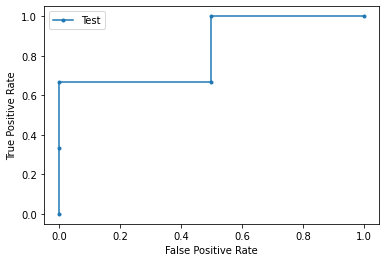

In [21]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot

y_true = np.array([0, 1, 1, 1, 0])
y_predicted = np.array([0.1, 0.7, 0.4, 0.2, 0.27])
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [22]:
print(roc_auc_score(y_true, y_predicted))

0.8333333333333333


## Меры качества многоклассовой классификации 

<table>
  <tr>
    <th></th>
    <th></th>
    <th colspan="3">gold <br>standart</th>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>$class_1$</td>
    <td>$class_2$</td>
    <td>$class_3$</td>
  </tr>
  <tr>
    <td rowspan="3">classification <br>output</td>
    <td>$class_1$</td>
    <td>$tp_1$</td>
    <td>$fp_{12}$</td>
    <td>$fp_{13}$</td>
  </tr>
  <tr>
    <td>$class_2$</td>
    <td>$fn_{21}$</td>
    <td>$tp_2$</td>
    <td>$fp_{23}$</td>
  </tr>
  <tr>
    <td>$class_3$</td>
    <td>$fn_{31}$</td>
    <td>$fn_{32}$</td>
    <td>$tp_3$</td>
  </tr>
</table>


Микро-усреднение:

$micro-precision = $micro-Pr$ =  \frac{\sum tp_i}{\sum tp_i + \sum fp_i} $ 

$micro-recall = $micro-R$ = \frac{\sum tp_i}{\sum tp_i+ \sum fn_i } $

Макро-усреднение:

$macro-precision = $macro-Pr$ =  \frac{\sum Pr_i}{|C|} $

$macro-recall = $macro-R$ = \frac{\sum R_i}{|C|} $ 





## Источники данных
* IMDB 
* newsgroups 20
* Reuters 
* Кинопоиск
* Wiki
* 


## (Напоминание) Вычисление расстояния / близости между документами 

Евклидово расстояние: $ dist( \vec{d_i}, \vec{d_j}) = \sqrt { \sum_{k} ( d_i^k - d_j^k)^2 }$

Косинусная мера близости: $ sim( \vec{d_i}, \vec{d_j}) =  \cos(\theta )=  \frac{ \vec{d_i}\cdot \vec{d_j} }{\| \vec{d_i} \|\|\vec{d_j} \|}$

## Метод ближайшего соседа  [Nearest neighbor classifier]

Найдем $k$ ближайших соседей (самых близких документов) для документа $d$. Посмотрим на то, каким классам относятся документы: выберем модальный класс – будем считать его классом $d$.





In [49]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data) #Learn the vocabulary dictionary and return term-document matrix.
X_train_counts.shape

(2257, 35788)

In [50]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier().fit(X_train_counts, twenty_train.target)

In [51]:
from sklearn.metrics import *
twenty_test = fetch_20newsgroups(subset='test', categories=categories, 
                                 shuffle=True, random_state=0)
X_test = count_vect.transform(twenty_test.data) # Extract token counts out of raw text documents using the vocabulary fitted with fit 
print(X_test.shape)
predicted = clf.predict(X_test)

(1502, 35788)


In [52]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.5599
micro F1=0.5599, micro P=0.5599, micro R=0.5599
macro F1=0.5507, macro P=0.5580, macro R=0.5963



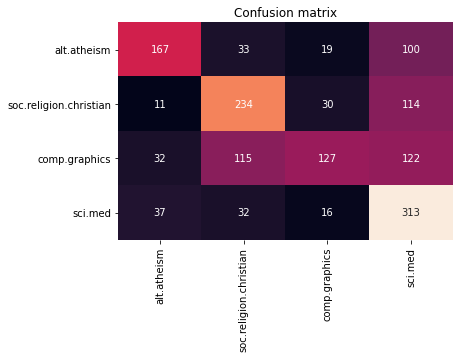

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

In [54]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => comp.graphics
OpenGL on the GPU is fast => comp.graphics


## Метод наивного Байеса  [Multinomial naive Bayes classifier]

Требуется оценить вероятность принадлежности документа $d \in D$ классу $c \in C$: $p(c|d)$. Каждый документ –  мешок слов, всего слов $|V|$.
	
$p(c)$ – априорная вероятность класса $c$
   
$p(c|d)$ – апостериорная вероятность класса $c$
	
	




$ p(c|d) = \frac{p(d|c)p(c)}{p(d)} $

Пусть документ $d$ описан признаками $f_1, \dots, f_N$.

$ c_{NB} = \arg \max _{c \in C} p (c|d) = \arg \max_{c \in C}  \frac{p(d|c)p(c)}{p(d)} \propto $
	
$ \propto \arg \max_{c \in C} p(d|c)p(c)  = \arg \max_{c \in C} p(f_1, f_2, \dots, f_{N} | c)p(c)$

### Предположение о независимости 

* Мешок слов: порядок слов не имеет значения
* Условная независимость (наивное предположение): вероятности признаков $p(f_i|c_j)$ внутри класса $c_j$ независимы

$p(f_1, f_2, \dots, f_{N} | c) \times  p(c) =   p(f_1|c) \times p(f_2|c) \times \dots \times p(f_{N}|c)  \times p(c)$



$C_{NB}=\arg \max_{c \in C} p(c) \times \prod_{1 \le i \le N} p(f_i|c) $

Допустим, что признаки $f_i$ – слова $w_i$, а $\texttt{positions}$ – все позиции слов в документе.


$C_{NB} = p(c) \times \prod_{i \in \texttt{positions}} p(w_i|c) $

<img src="https://raw.githubusercontent.com/echernyak/ML-for-compling/d6b4f82e788cd7b365ea711db2ac4b0fc7a361d0/img/bow.png" width="600">

### Обучение наивного Байесовского классификатора

#### ММП оценки вероятностей:
	
$ \widehat{p_(c_j)} = \frac{| \{d| d \in c_j\} |}{|D|} $
	
$ \widehat{p(w_i | c_j)} = \frac{\texttt{count}(w_i, c_j)}{\sum_{w \in V} \texttt{count}(w, c_j)} $
	
Создаем $|C|$ мегадокументов: каждый документ = все документы в одном классе, склеенные в один мегадокумент и вычисляем частоты $w$ в мегадокументах.
	


#### Проблема нулевых вероятностей:  

$\texttt{count}(w_i, c_j)$ может быть равно нулю. 

Допустим, что каждое слово встречается как минимум $\alpha$ раз в мешке слов.
	
Преобразование Лапласа: $ \frac{+\alpha}{+\alpha |V|}$
	
$ \widehat{p(w_i | c_j)} = \frac{\texttt{count}(w_i, c_j) + \alpha}{(\sum_{w \in V} \texttt{count}(w, c_j)) + \alpha |V| } $

### Пример. Тематическая классификация
	
    


<table>
  <tr>
    <th></th>
    <th>документ</th>
    <th>класс</th>
  </tr>
  <tr>
    <td rowspan="4">обучающее<br>множество</td>
    <td>Chinese Beijing Chinese</td>
    <td>c</td>
  </tr>
  <tr>
    <td>Chinese Chinese Shanghai</td>
    <td>c</td>
  </tr>
  <tr>
    <td>Chinese Macao</td>
    <td>c</td>
  </tr>
  <tr>
    <td>Tokyo Japan Chinese</td>
    <td>j</td>
  </tr>
  <tr>
    <td>тестовое<br>множество</td>
    <td>Chinese Chinese Chinese Tokyo Japan</td>
    <td>?</td>
  </tr>
</table>




$p(c) =\frac{3}{4}$,$p(j) = \frac{1}{4}$

$p(\texttt{Chinese|c)}= (5+1)/(8+6)=6/14=3/7$  

$p(\texttt{Chinese|j)}= (1+1)/(3+6)=2/9$  

$p(\texttt{Tokyo|c)}= (0+1)/(8+6)=1/14$  

$p(\texttt{Tokyo|j)}= (1+1)/(3+6)=2/9$  

$p(\texttt{Japan|c)}= (0+1)/(8+6)=1/14$  

$p(\texttt{Japan|j)}= (1+1)/(3+6)=2/9$


$p(c|d_5) = 3/4 \times (3/7)^3 \times 1/14 \times 1/14 \approx 0.0003$

$p(j|d_5) = 1/4 \times (2/9)^3 \times 2/9 \times 2/9 \approx 0.0001$

### Мультиномиальный наивный Байсовский классификатор

Слова в тексте распределены по мультиномиальному закону: документ – это последовательность событий. Каждое событие – это случайный выбор одного слова из мешка слов. Мы перемножаем вероятности встреченных слов в предположении, что каждое событие независимо. Таким образом мы получаем мультиномиальную  модель. 

In [55]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

In [56]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.9341
micro F1=0.9341, micro P=0.9341, micro R=0.9341
macro F1=0.9330, macro P=0.9326, macro R=0.9341



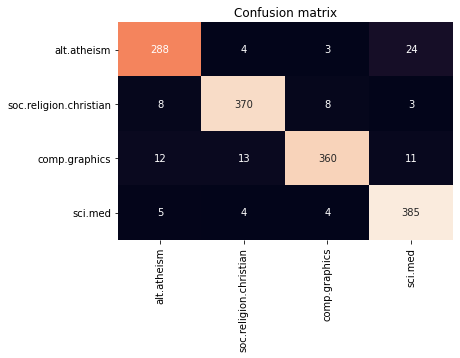

In [57]:
sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

In [58]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => soc.religion.christian
OpenGL on the GPU is fast => comp.graphics


## Логистическая регрессия (метод максимальной энтропии [MaxEnt])

Требуется оценить вероятность принадлежности документа $d \in D$ классу $c \in C$: $p(c|d)$. Пусть заданы признаки  $f_i \in F$ – множество признаков и  $w_i$ – их веса. 

Признаки могут зависеть от классов: $f_i(c,d)$  

Линейная комбинация этих признаков: $\sum_{i=1}^k w_i f_i(c,d)$.  

Как связана $\sum_{i=1}^k w_i f_i(c,x)$ и $p(c|d)$?
	
$p(c|d) = \frac{1}{Z} e^{\sum_{i=1}^k w_i f_i(c,d)},$
	
где $\frac{1}{Z} = \frac{1}{\sum_{c' \in C} e^{\sum_{i=1}^k w_i f_i(c',d)} }.$

$ \widehat{c} = \texttt{argmax}_{c \in C} p (c|d) = \texttt{argmax}_{c \in C} \frac{e^{\sum_{i=1}^k w_i f_i(c,d)}}{\sum_{c' \in C} e^{\sum_{i=1}^k w_i f_i(c',d)}}  \propto  \texttt{argmax}_{c \in C} e^{\sum_{i=1}^k w_i f_i(c,d)}   \propto  \texttt{argmax}_{c \in C} \sum_{i=1}^k w_i f_i(c,d).  $


### Пример. Классификация по тональности на $C = <+,->$
	
Используем индикаторные признаки
	

*... there are virtually no surprises, and the writing is second-rate. So why did I enjoy it so much? For one thing, the cast is great ...*
	 

<table>
  <tr>
    <th>признак</th>
    <th>значение</th>
    <th></th>
    <th>вес</th>
  </tr>
  <tr>
    <td>$f_1$</td>
    <td>1</td>
    <td> "great" $\in d$ и $c=+$</td>
    <td rowspan="2">1.9</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>
  
   <tr>
    <td>$f_2$</td>
    <td>1</td>
    <td>"second-rate" $\in d$ и $c=-$</td>
    <td rowspan="2">0.9</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>

   <tr>
    <td>$f_3$</td>
    <td>1</td>
    <td>"no" $\in d$ и $c=-$ </td>
    <td rowspan="2">0.7</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>
  
   <tr>
    <td>$f_4$</td>
    <td>1</td>
    <td>"enjoy" $\in d$ и $c=-$ </td>
    <td rowspan="2">-0.8</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>

   <tr>
    <td>$f_4$</td>
    <td>1</td>
    <td>"great" $\in d$ и $c=-$ </td>
    <td rowspan="2">-0.6</td>
  </tr>
  <tr>
    <td></td>
    <td>0</td>
    <td>иначе</td>
  </tr>




</table>
	






класс $+$:  $1.9 + 0 + 0 + 0 + 0 = 1.9$
	
класс $-$: $0 + 0.9 + 0.7 - 0.8 - 0.6 =0.2$

$p(+|d) = \frac{e^{1.9}}{e^{1.9}+e^{0.2}}$
	
$p(-|d) = \frac{e^{0.2}}{e^{1.9}+e^{0.2}}$

In [59]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [60]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8908
micro F1=0.8908, micro P=0.8908, micro R=0.8908
macro F1=0.8878, macro P=0.8868, macro R=0.8944



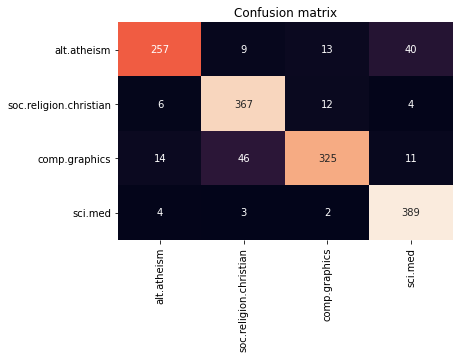

In [61]:

sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

In [62]:
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => soc.religion.christian
OpenGL on the GPU is fast => comp.graphics


## Метод опорных векторов [Support vector machine, SVM]


<img src="https://raw.githubusercontent.com/echernyak/ML-for-compling/d6b4f82e788cd7b365ea711db2ac4b0fc7a361d0/img/svm_1.png" width="200" align='right'>


$a(x) = sign(<w,x>+b)$ – классификатор, задающий разделяющую гиперплоскость

$ \min_{x \in X} |<w,x>+b| = 1$ – нормировка параметров

Требуется построить разделяющую гиперплоскость шириной $ \frac{2}{||w||}$ (т.е. $2 ~ \times $ расстояние от разделяющей гиперплоскости до ближайшего объекта обучающего множества, иначе отступ).


Оптимизационная задача (если выборка линейно разделима):

$ \frac{1}{2} ||w||^2 \rightarrow \min_{w,b} $

$ y_i(<w_i, x_i> + b) \geq 1 $



Конспекты Е. Соколова: https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture05-linclass.pdf

Multi-class SVM: https://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html

In [63]:
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

In [64]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8908
micro F1=0.8908, micro P=0.8908, micro R=0.8908
macro F1=0.8880, macro P=0.8868, macro R=0.8936



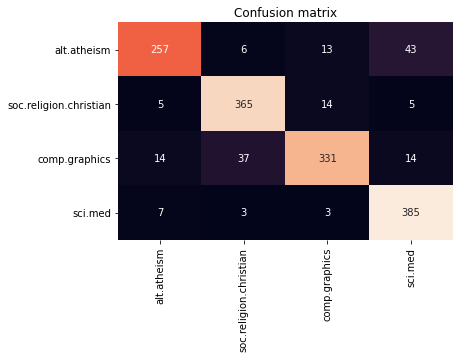

In [65]:
sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

In [66]:
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => soc.religion.christian
OpenGL on the GPU is fast => comp.graphics


## Деревья решений 



<img src="https://raw.githubusercontent.com/echernyak/ML-for-compling/d6b4f82e788cd7b365ea711db2ac4b0fc7a361d0/img/decision-tree.png" width="300" align='center'>

In [67]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

In [68]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.7390
micro F1=0.7390, micro P=0.7390, micro R=0.7390
macro F1=0.7357, macro P=0.7363, macro R=0.7407



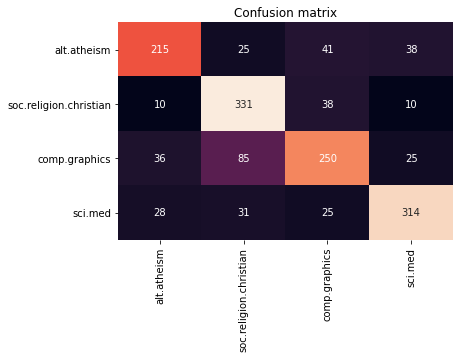

In [69]:
sns.heatmap(data=confusion_matrix(twenty_test.target, predicted), annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.title("Confusion matrix")
plt.show()

# Отбор признаков



**Веса** :
* $tf-idf$, $\chi^2$ для взвешивания слов
* меры ассоциации биграм для отбора биграм: $(P)PMI$, $t-score$




**Уменьшение количества признаков**:
* лемматизация
* стемминг
* удаление стоп-слов
* пороги на частоту ($min\_tf$)
* пороги на документную частоту ($max\_df$)




**Признаки**:
* $n$-грамы 
* символьные $n$-грамы  (подслова, subwords)
* именованные сущности 
* термины
* "не\_" + слово 
* сохраним $N$ самых частых слов, остальные представим подсловами и символьными
$n$-грамами



** Снижение размерности **:
* скрытые темы в качестве признаков

# Конвеер в sklearn

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (2,3))), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())])
text_clf

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(2, 3))),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [71]:
text_clf.fit(twenty_train.data, twenty_train.target)  
predicted = text_clf.predict(twenty_test.data)

In [72]:
acc = accuracy_score(predicted, twenty_test.target)
micro_f1 = f1_score(predicted, twenty_test.target, average = 'micro')
micro_p = precision_score(predicted, twenty_test.target, average = 'micro')
micro_r = recall_score(predicted, twenty_test.target, average = 'micro')
macro_f1 = f1_score(predicted, twenty_test.target, average = 'macro')
macro_p = precision_score(predicted, twenty_test.target, average = 'macro')
macro_r = recall_score(predicted, twenty_test.target, average = 'macro')
print('acc={0:1.4f}'.format(acc))
print('micro F1={0:1.4f}, micro P={1:1.4f}, micro R={2:1.4f}'.format(micro_f1, micro_p, micro_r))
print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\n'.format(macro_f1, macro_p, macro_r))

acc=0.8216
micro F1=0.8216, micro P=0.8216, micro R=0.8216
macro F1=0.8222, macro P=0.8184, macro R=0.8481



In [73]:
predicted = clf.predict(X_new_counts)

for doc, category in zip(docs_new, predicted):
    print('{} => {}'.format(doc, twenty_train.target_names[category]))

God is love => soc.religion.christian
OpenGL on the GPU is fast => comp.graphics


# Метрики качества регрессии 

In [75]:
Image(url="https://4.bp.blogspot.com/-wG7IbjTfE6k/XGUvqm7TCVI/AAAAAAAAAZU/vpH1kuKTIooKTcVlnm1EVRCXLVZM9cPNgCLcBGAs/s1600/formula-MAE-MSE-RMSE-RSquared.JPG",
     width=400, height=400)

In [78]:
Image(url="https://i.stack.imgur.com/OFZby.jpg",
     width=700, height=400)

На этом занятии мы попробуем задачу регрессии. Данные возьмем вот эти - https://www.kaggle.com/budincsevity/szeged-weather

Открытые датасеты можно найти тут - https://archive.ics.uci.edu/ml/index.php или тут https://github.com/sebastianruder/NLP-progress (самих датасетов тут нет, но есть ссылки)


In [47]:
import pandas as pd

In [48]:
weather_hist = pd.read_csv('weatherHistory.csv')

Первым делом стоит посмотреть на размер датасета

In [49]:
weather_hist.shape
# (#строчек, #колонок)

(96453, 12)

In [50]:
weather_hist.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [51]:
## По умолчанию Pandas выводит всего 20 столбцов и 60 строк, 
## поэтому если ваш датафрейм больше, воспользуйтесь функцией set_option
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Посмотреть все колонки датасета можно вот так

In [53]:
# можно переименовать колонки
weather_hist.rename({'Formatted Date':'date', 'Temperature (C)':'temp', 'Apparent Temperature (C)':'temp_app',
                    'Precip Type':'weather_type', 'Wind Speed (km/h)':'wind_speed', 'Humidity':'humidity',
                    'Daily Summary':'summary'}, 
                    axis=1, inplace=True)

In [54]:
# а можно создать новую колонку и присвоить ей значение старой, а затем отбросить старую
weather_hist['visibility'] = weather_hist['Visibility (km)']
weather_hist['wind_bearing'] = weather_hist['Wind Bearing (degrees)']
weather_hist['pressure'] = weather_hist['Pressure (millibars)']
weather_hist.drop(['Visibility (km)', 'Wind Bearing (degrees)', 'Pressure (millibars)'], axis=1, inplace=True)

In [55]:
weather_hist.head(5)

,date,Summary,weather_type,temp,temp_app,humidity,wind_speed,Loud Cover,summary,visibility,wind_bearing,pressure
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,0.0,Partly cloudy throughout the day.,15.8263,251.0,1015.13
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,0.0,Partly cloudy throughout the day.,15.8263,259.0,1015.63
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,0.0,Partly cloudy throughout the day.,14.9569,204.0,1015.94
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,0.0,Partly cloudy throughout the day.,15.8263,269.0,1016.41
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,0.0,Partly cloudy throughout the day.,15.8263,259.0,1016.51


В 5 строчках, на которые мы посмотрели в колонке Loud Cover одни нули. Давайте проверим, не бесполезная ли это колонка.

In [56]:
# кроме нулей ничего нет
weather_hist['Loud Cover'].unique()

array([0.])

Отбросим эту колонку

In [57]:
weather_hist.drop(['Loud Cover'], axis=1, inplace=True)

Можно посчитать статистики для отдельных колонок

In [58]:
weather_hist['temp'].mean(), weather_hist['temp'].std()

(11.93267843751188, 9.551546320657026)

In [59]:
weather_hist['temp_app'].min(), weather_hist['temp_app'].max()

(-27.716666666666665, 39.344444444444434)

Есть удобная функция .describe(), которая собирает основные статистики для всех численных колонок.

In [60]:
weather_hist.describe()

,temp,temp_app,humidity,wind_speed,visibility,wind_bearing,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,10.347325,187.509232,1003.235956
std,9.551546,10.696847,0.195473,6.913571,4.192123,107.383428,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.688889,2.311111,0.600000,5.828200,8.339800,116.000000,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,10.046400,180.000000,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,14.812000,290.000000,1021.090000
max,39.905556,39.344444,1.000000,63.852600,16.100000,359.000000,1046.380000


In [61]:
weather_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
date            96453 non-null object
Summary         96453 non-null object
weather_type    95936 non-null object
temp            96453 non-null float64
temp_app        96453 non-null float64
humidity        96453 non-null float64
wind_speed      96453 non-null float64
summary         96453 non-null object
visibility      96453 non-null float64
wind_bearing    96453 non-null float64
pressure        96453 non-null float64
dtypes: float64(7), object(4)
memory usage: 8.1+ MB


Из этих статистик уже можно сделать какие-то выводы.  

1) видно, что в оставшихся данных нет пропусков.   
2) видно, что у колонок разные единицы измерения и соответствено значения разные (где-то от 0 до 1, где-то от -21 до 27)  
3) Temperature (C) и Apparent Temperature (C) очень похожи, но если посмотреть на Min и Max, то можно сделать вывод, что ощущаемая температура может отличаться только в меньшую сторону  

Чтобы посмотреть, как колонки связаны между собой, можно посчитать корреляцию.

In [62]:
# метод corr считает корреляцию всех колонок со всеми (острожнее, если у вас большой датасет)
weather_hist.corr()

,temp,temp_app,humidity,wind_speed,visibility,wind_bearing,pressure
temp,1.000000,0.992629,-0.632255,0.008957,0.392847,0.029988,-0.005447
temp_app,0.992629,1.000000,-0.602571,-0.056650,0.381718,0.029031,-0.000219
humidity,-0.632255,-0.602571,1.000000,-0.224951,-0.369173,0.000735,0.005454
wind_speed,0.008957,-0.056650,-0.224951,1.000000,0.100749,0.103822,-0.049263
visibility,0.392847,0.381718,-0.369173,0.100749,1.000000,0.047594,0.059818
wind_bearing,0.029988,0.029031,0.000735,0.103822,0.047594,1.000000,-0.011651
pressure,-0.005447,-0.000219,0.005454,-0.049263,0.059818,-0.011651,1.000000


Для наглядности можно нарисовать тепловую карту.

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

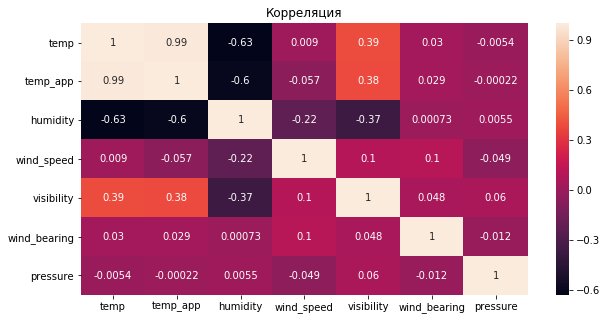

In [64]:

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=weather_hist.corr(), 
            annot=True, ax=ax)
plt.title("Корреляция")
plt.show()

Из тепловой карты можно сделать вывод, что 1) влажность негативно скоррелирована с температурой, а вот 2) скорость ветра с температурой почти никак не связана, хотя 3) связана, с влажностью. 4) Видимость связана с влажностью и с температурой. 

Ещё можно нарисовать ящик с усами для каждой из колонок, чтобы посмотреть, нет ли в данных выбросов:

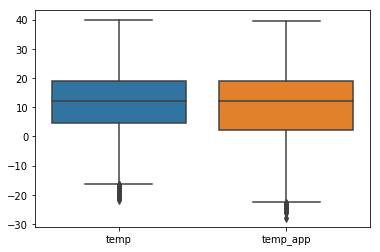

In [21]:
ax = sns.boxplot(data=weather_hist[['temp', 'temp_app']])

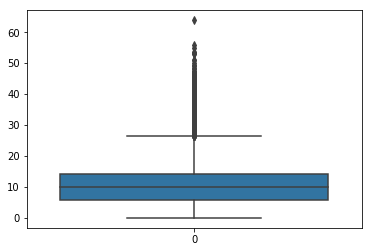

In [22]:
ax = sns.boxplot(data=weather_hist['wind_speed'])

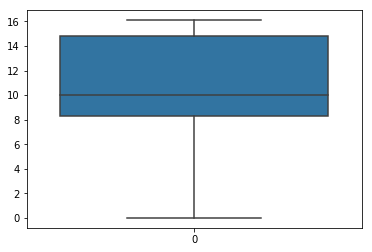

In [23]:
ax = sns.boxplot(data=weather_hist['visibility'])

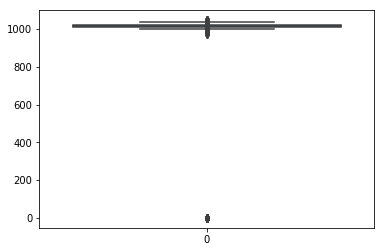

In [24]:
ax = sns.boxplot(data=weather_hist['pressure'])

Нулевым давление быть не может. Скорее всего это пропуск в данных. Посмотрим сколько таких 0.

In [25]:
weather_hist['pressure'].value_counts()

0.00       1288
1017.70     123
1015.00     119
1018.00     118
1015.80     118
1019.10     117
1016.70     117
1016.90     115
1015.90     114
1017.40     114
1016.50     114
1017.30     114
1018.70     112
1017.10     112
1017.60     111
1015.10     111
1014.90     110
1016.10     110
1017.90     109
1019.60     108
1016.80     108
1017.80     107
1014.50     106
1018.90     105
1020.20     105
1019.70     105
1017.20     104
1019.00     104
1016.30     104
1016.60     104
1015.70     104
1018.20     103
1015.50     102
1016.40     101
1017.50     101
1014.70     100
1014.40      98
1019.90      97
1018.80      96
1013.80      96
1018.10      96
1014.80      96
1013.50      95
1015.30      95
1018.40      95
1015.20      95
1014.60      94
1017.00      93
1018.60      93
1019.80      92
           ... 
1040.28       1
1044.35       1
1002.36       1
991.75        1
986.87        1
1044.60       1
996.57        1
1043.78       1
1000.29       1
994.77        1
987.06        1
994.52  

In [23]:
weather_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 11 columns):
date            96453 non-null object
Summary         96453 non-null object
weather_type    95936 non-null object
temp            96453 non-null float64
temp_app        96453 non-null float64
humidity        96453 non-null float64
wind_speed      96453 non-null float64
summary         96453 non-null object
visibility      96453 non-null float64
wind_bearing    96453 non-null float64
pressure        96453 non-null float64
dtypes: float64(7), object(4)
memory usage: 8.1+ MB


С такими нулями можно поступить двумя способами - просто выкинуть или заменить на какое-то более реальное значение (например, усредненное давление).

In [24]:
weather_hist = weather_hist[weather_hist['pressure'] > 100]

In [45]:
weather_hist[weather_hist['pressure'] < 100]['pressure'] = weather_hist['pressure'].mean()

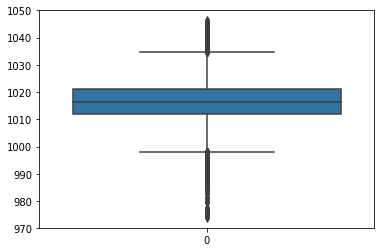

In [46]:
ax = sns.boxplot(data=weather_hist['pressure'])

Теперь давайте подключим категориальные переменные.

Можно сгруппировать данные по значениям rain и snow и посчитать те же статистики внутри этих групп.

In [66]:
weather_hist.Summary.unique()

array(['Partly Cloudy', 'Mostly Cloudy', 'Overcast', 'Foggy',
       'Breezy and Mostly Cloudy', 'Clear', 'Breezy and Partly Cloudy',
       'Breezy and Overcast', 'Humid and Mostly Cloudy',
       'Humid and Partly Cloudy', 'Windy and Foggy', 'Windy and Overcast',
       'Breezy and Foggy', 'Windy and Partly Cloudy', 'Breezy',
       'Dry and Partly Cloudy', 'Windy and Mostly Cloudy',
       'Dangerously Windy and Partly Cloudy', 'Dry', 'Windy',
       'Humid and Overcast', 'Light Rain', 'Drizzle', 'Windy and Dry',
       'Dry and Mostly Cloudy', 'Breezy and Dry', 'Rain'], dtype=object)

In [67]:
weather_hist.groupby('Summary').agg(['mean'])

,temp,temp_app,humidity,wind_speed,visibility,wind_bearing,pressure
,mean,mean,mean,mean,mean,mean,mean
Summary,,,,,,,
Breezy,7.922016,3.387654,0.637778,32.143948,9.577115,233.018519,563.917593
Breezy and Dry,21.111111,21.111111,0.260000,33.810000,9.982000,240.000000,1021.600000
Breezy and Foggy,-0.510317,-7.403492,0.938571,33.477880,1.621960,160.628571,1008.934000
Breezy and Mostly Cloudy,11.093411,8.680588,0.637054,33.386345,11.478302,227.639535,1000.622984
Breezy and Overcast,7.241614,3.492235,0.763144,33.037566,11.067012,213.526515,1002.114924
Breezy and Partly Cloudy,12.492761,9.989349,0.545803,33.532796,11.326058,259.282383,996.398212
Clear,11.925109,11.040338,0.729708,8.141352,11.441788,179.180257,951.763532
Dangerously Windy and Partly Cloudy,8.944444,3.483333,0.490000,63.852600,11.447100,307.000000,1009.050000


## Регрессия в sklearn

Давайте теперь попробуем предсказывать какую-то из колонок. Для простоты оставим только численные колонки. 


In [68]:
# можно переопределить датасет его частью
weather_hist = weather_hist[['temp',
       'temp_app', 'humidity', 'wind_speed',
       'wind_bearing', 'visibility', 'pressure']]

Попробуем несколько базовых регрессоров в sklearn.

In [79]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR

Sklearn умееть работать и с dataframe из пандаса (если там только числа), но часто матрицу объекты-признаки и целевую переменную удобно вынести в отдельные переменные в виде numpy массива. 

In [70]:
X = weather_hist.drop('wind_speed', axis=1).values
y = weather_hist['wind_speed'].values

In [71]:
from sklearn.model_selection import train_test_split

Валидация (т.е. проверка качеста) моделей отдельная сложная тема, но главное правило простое - не оценивай качество модели на данных, на которых обучался. Просто отложенная тестовая выборка уже спасет от большинства проблем. 

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Ridge - это линейная регрессия с l2 регуляризацией. То есть строится модель, которая суммирует признаки с каким-то весами, чтобы получить предсказание. Веса подбираются во время обучения и на их значение накладывается ограничение (регуляризация), так чтобы они не получались слишком большими.

In [85]:
# силу регуляризации можно варьировать параметром alpha
regressor = Lasso(alpha=10)
regressor.fit(X_train, y_train)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [86]:
list(zip(weather_hist.columns, regressor.coef_))

[('temp', 0.0),
 ('temp_app', -0.0),
 ('humidity', -0.0),
 ('wind_speed', 0.005622381164772534),
 ('wind_bearing', 0.0),
 ('visibility', -0.0021509345515767597)]

Чтобы оценить качество модели, предскажем значения целевой переменной на тестовой выборке и сравним с настоящими значениями.

In [76]:
preds = regressor.predict(X_test)

В качестве метрики будем использовать среднюю абсолютную ошибку. Она показывает отклонение от правильного ответа в тех же единах измерения.

In [77]:
from sklearn.metrics import mean_absolute_error

In [78]:
mean_absolute_error(y_test, preds)

4.119277729666935

Т.е. в среднем мы ошибаемся в скорости ветра на 4 км/ч

Попробуем другие алгоритмы.

Иногда бывает полезно стандартизировать данные (отнять среднее и поделить на стандартное отклонение). После стандартизации среднее всех колонок будет равно 0, а стандартное отклонение 1. Это позволяет исправить ситуацию, когда признаки представлены в разных единацах измерения. 
Для этого используется StandardScaler. 

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(sc.fit_transform(X), y, random_state=42)

До стандартизации:

In [40]:
list(X[0])

[9.472222222222221,
 7.388888888888887,
 0.89,
 251.0,
 15.826300000000002,
 1015.13]

После:

In [41]:
list(sc.fit_transform(X)[0])

[-0.2594808561597769,
 -0.3265377477383117,
 0.7926624413965685,
 0.591888531901622,
 1.3005175654507883,
 -0.2165173590801981]

In [42]:
regressor = Ridge()
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
mean_absolute_error(y_test, preds)

4.0498391481920475

In [43]:
regressor = Ridge(alpha=0.01)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
mean_absolute_error(y_test, preds)

4.049473722959159

Lasso - линейная регрессия с l1 регуляризацией. Она немного медленее Ridge и обычно работает немного хуже, но она позволяет проводить отбор признаков.

In [44]:
regressor = Lasso(alpha=1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
mean_absolute_error(y_test, preds)

5.100549160777688

In [45]:
list(zip(weather_hist.columns, regressor.coef_))

[('temp', -0.0),
 ('temp_app', -0.0),
 ('humidity', -0.5172190895813394),
 ('wind_speed', 0.0),
 ('wind_bearing', 0.0),
 ('visibility', -0.7418107638971679)]

Такая модель использует для предсказания только влажность. В реальной задаче, нулевые признаки можно выбросить, для того, чтобы упросить модель (если качество устраивает конечно).

Попробуем SVM. Вообще SVM лучше подходит для классификации. Для регрессии в итоге получается такая же модель как и в линейной регрессии (прямая == взвешенная сумма признаков). Только подбор параметров тут происходит по-другому и поэтому результат может отличаться.

In [46]:
regressor = LinearSVR(C=1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
mean_absolute_error(y_test, preds)

3.9243397901552832

Качество даже немного улучшилось.

## Регрессия на тексте

При работе с текстом, как правило, приходится решать задачу классификации. Но бывают и случаи, где по тексту нужно предсказать число. Например, на Kaggle проводилось соревнование по прогнозированию вероятности покупки товара.   
Ссылка на соревнование - https://www.kaggle.com/c/avito-demand-prediction

Одним из признаков там было текстовое описание товара. 

Давайте выкинем все остальные признаки и попробуем только по тексту предсказать вероятность покупки. Алгоритмы тут можно использовать те же самые, но сами тексты нужны предварительно векторизовать.

Изначальный датасет достаточно большой, поэтому возьмем случайную подвыборку из него. (Я сделал это за вас. Если хотите поработать со всеми данными, скачайте их на сайте соревнования (только train.csv, иначе придется 123 гб скачивать) и раскомментируйте ячейки ниже)

In [137]:
# data = pd.read_csv('train.csv.zip')
# data.dropna(subset=['description'], inplace=True) # так выкидываются строчки с пропусками в колонке description

In [ ]:
data = data.sample(frac=0.08)

In [49]:
# data.to_csv('data.csv', index=None)

In [131]:
data = pd.read_csv('data.csv')

In [132]:
data.shape

(138715, 18)

In [136]:
data.head(5)

,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image_top_1,deal_probability
0,Бытовая электроника,Телефоны,Xiaomi,NaN,NaN,Xiaomi RedMI 4a,"Телефон новый, не использованный, в заводской ...",6900.0,22,2017-03-26,Private,2944.0,0.16933
1,Транспорт,Автомобили,С пробегом,Audi,Q5,"Audi Q5, 2009",Продам автомобиль AUDI SUV Stronic Quattro 2.0...,890000.0,6,2017-03-16,Private,1132.0,0.26029
2,Личные вещи,Детская одежда и обувь,Для мальчиков,Верхняя одежда,98-104 см (2-4 года),Толстовка очень теплая,"на меху, очень теплая, хорошее состояние , бол...",500.0,123,2017-03-27,Private,61.0,0.80323
3,Бытовая электроника,Телефоны,iPhone,NaN,NaN,"Продаю айфон 6 16 гб сильвер с зарядкой,без ко...","Продаю айфон 6 16 гб сильвер с зарядкой,без ко...",23000.0,7,2017-03-15,Private,2918.0,0.03486
4,Животные,Аквариум,NaN,NaN,NaN,Аквариум,Аквариум для маленьких рыбок+корм+грунт+подста...,1000.0,109,2017-03-25,Company,1718.0,0.00000


Чтобы понимать, что наши модели делают что-то полезное, посчитаем качество для случайного предсказания и для предсказания средей вероятности.

В соревновании была другая метрика - RMSE. Её нет в sklearn, но её легко сделать из MSE и np.sqrt

Если хотите получше узнать о numpy, поделайте упражнения в этом репозитории - https://github.com/Kyubyong/numpy_exercises

In [93]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [94]:
y_train, y_test = train_test_split(data.deal_probability, random_state=42)

Cлучайное предсказание

In [95]:
np.random.rand(len(y_test))

array([0.93165905, 0.24946652, 0.96071886, ..., 0.74287804, 0.06574641,
       0.01829222])

In [98]:
np.sqrt(mean_squared_error(y_test, np.random.rand(len(y_test))))

0.5285613167194422

Среднее предсказание 

In [99]:
np.full(len(y_test), np.mean(y_train))

array([0.14566944, 0.14566944, 0.14566944, ..., 0.14566944, 0.14566944,
       0.14566944])

In [100]:
np.sqrt(mean_squared_error(y_test, np.full(len(y_test), np.mean(y_train))))

0.26367475849307315

Можно посчитать статистики по тексту и на этом обучить модель.

In [101]:
data['text_len'] = data['description'].apply(len)
data['text_len_tokens'] = data['description'].apply(lambda x: len(x.split()))
data['number_of_caps'] = data['description'].apply(lambda x: len([ch for ch in x if ch.isupper()]))
data['number_of_nonalphanum'] = data['description'].apply(lambda x: len([ch for ch in x if not ch.isalnum()]))

In [102]:
X = data[['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum']].values
y = data.deal_probability.values

Проверим размер получившейся матрицы.

In [103]:
X.shape

(138715, 4)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [105]:
regressor = Ridge(alpha=1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.2633314826860365

Для векторизации можно использовать CountVectorizer или TfidfVectorizer. Они собирают словарь слов, которые используются в данных и с помощью него составляют вектора, в которых ненулевые значения показывают, что в конкретном тексте есть соответствующие слова из словаря.

В CountVectrizer значения - частоты слов в тексте, а в TfidfVectorizer - частоты, домноженные на idf.

In [107]:
x

In [108]:
cv = CountVectorizer(max_features=1000, min_df=5, max_df=0.4, ngram_range=(1,2))
X = cv.fit_transform(data.description)
y = data.deal_probability.values

In [109]:
X.shape

(138715, 1000)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [111]:
regressor = Ridge(alpha=10)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.25122001490550927

In [112]:
cv = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.4)
X = cv.fit_transform(data.description)
y = data.deal_probability.values

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [118]:
regressor = Ridge(alpha=1)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.24837284431865686

Когда данных много, то обычные модели в sklearn могут работать долго или занимать слишком много памяти. В этом случае может помочь SGDRegressor. Это та же линейная регрессия (или SVM если поменять loss), но обучающая на кусочках данных (батчах). Можно настроить количество проходов по датасету (max_iter) так, чтобы качество получалось достаточно хорошее, но времени на это уходило как можно меньше. 

In [115]:
from sklearn.linear_model import SGDRegressor

In [119]:
regressor = SGDRegressor(max_iter=10, alpha=0.00001)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.25106011838562586

Можно попробовать объединить матрицы из CountVectorizer и TfidfVectorizer. Они возвращают sparse матрицы (т.е. там в основном нули), чтобы сэкономить память. Для конкатенации таких матриц в scipy есть функция hstack.

In [120]:
from scipy.sparse import hstack

In [121]:
cv = CountVectorizer(max_features=1000, min_df=5, max_df=0.4, ngram_range=(1,2))
tfidf = TfidfVectorizer(max_features=1000, min_df=5,analyzer='char', ngram_range=(3,3), max_df=0.4)

X_cv = cv.fit_transform(data.description)
X_tfidf = tfidf.fit_transform(data.description)

X = hstack([X_cv, X_tfidf])

In [122]:
X_cv.shape, X_tfidf.shape

((138715, 1000), (138715, 1000))

In [123]:
X.shape

(138715, 2000)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [125]:
regressor = SGDRegressor(max_iter=50, alpha=0.00001)
regressor.fit(X_train, y_train)
preds = regressor.predict(X_test)
np.sqrt(mean_squared_error(y_test, preds))

0.248087194219948

Для того, чтобы понять, насколько признаки объясняют целевую переменную, можно посчитать коэффициент детерминации. 

In [126]:
from sklearn.metrics import r2_score

In [127]:
r2_score(y_test, preds)

0.11473846322559045

Для точных совпадений он будет равен 1.

In [128]:
r2_score(y_test, y_test)

1.0

Но он может сильно ниже нуля, если модель совсем плохая.

In [129]:
# всегда предсказывает тысячу
r2_score(y_test, np.full(len(y_test), 1000))

-14379255.669139741